##### Needed imports and authentication

In [2]:
! pip install mlflow

In [1]:
# authentication
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient

import os
import mlflow  # needed pip above?
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from azure.ai.ml.entities import Model

credential = DefaultAzureCredential()

ml_client = MLClient(
    credential=credential,
    subscription_id="d33b5db8-15df-4c49-9e44-ff5ac32d6bb6", # Azure for Students subscription
    workspace_name="AzureMLOps", 
    resource_group_name="bandsmlopsfall2025" 
)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/mlflow/__init__.py:41: UserWarning: Versions of mlflow (3.1.1) and mlflow-skinny (2.22.1) are different. This may lead to unexpected behavior. Please install the same version of both packages.
  mlflow.mismatch._check_version_mismatch()


##### Data preparation run

In [2]:
# First create mlflow experiment
mlflow.set_experiment("mini-project-experiment")

# Build data prep run/job
with mlflow.start_run(run_name="data prep run") as run:
    # use latest data asset version
    data_asset = ml_client.data.get(name="telecom_churn_dataset", label="latest")

    # load data 
    df = pd.read_csv(data_asset.path)

    # EDA and preprocessing

    print(df.dtypes) # check data types (print)
    null_count = df.isnull().sum().sum() # check for any nulls

    duplicate_count = df.duplicated().sum() # check for duplicates

    # examine target distribution
    churn_distribution = df['Churn'].value_counts(normalize=True) * 100

    # additional feature
    df['ServiceCallsPerWeek'] = df['CustServCalls'] / df['AccountWeeks']

    # set test/validation size and target column
    test_size = 0.3
    target_column_name = 'Churn'

    X_train, X_test, Y_train, Y_test = train_test_split(
        df[df.columns.difference([target_column_name]).values],
        df[target_column_name],
        stratify=df[target_column_name], # EDA confirmed stratification is needed
        test_size=test_size,
        random_state=12345
    )
    
    # Log metrics and parameters with mlflow
    
    # preprocessing transformations
    mlflow.log_metric("Nulls count in dataset", null_count)
    mlflow.log_metric("Duplicate count in dataset", duplicate_count)
    mlflow.log_metric("Churn rate percent", churn_distribution[0])
    mlflow.log_metric("No churn rate percent", churn_distribution[1])

    # new feature logging
    mlflow.log_param("engineered_feature", "ServiceCallsPerWeek")
    mlflow.log_param("feature_description", "Customer service calls per week (CustServCalls/AccountWeeks)")
      
    mlflow.log_metric("Test set size", test_size) # lastly, test size proportion
   

Churn                int64
AccountWeeks         int64
ContractRenewal      int64
DataPlan             int64
DataUsage          float64
CustServCalls        int64
DayMins            float64
DayCalls             int64
MonthlyCharge      float64
OverageFee         float64
RoamMins           float64
dtype: object
🏃 View run data prep run at: https://eastus2.api.azureml.ms/mlflow/v2.0/subscriptions/d33b5db8-15df-4c49-9e44-ff5ac32d6bb6/resourceGroups/bandsmlopsfall2025/providers/Microsoft.MachineLearningServices/workspaces/azuremlops/#/experiments/4fe9e28e-7f9d-4023-857b-78d39d0f636c/runs/fa31f221-acf2-4c61-986d-195834dece4c
🧪 View experiment at: https://eastus2.api.azureml.ms/mlflow/v2.0/subscriptions/d33b5db8-15df-4c49-9e44-ff5ac32d6bb6/resourceGroups/bandsmlopsfall2025/providers/Microsoft.MachineLearningServices/workspaces/azuremlops/#/experiments/4fe9e28e-7f9d-4023-857b-78d39d0f636c


##### Model creation run - Random Forest

🏃 View run model building and evaluation run at: https://eastus2.api.azureml.ms/mlflow/v2.0/subscriptions/d33b5db8-15df-4c49-9e44-ff5ac32d6bb6/resourceGroups/bandsmlopsfall2025/providers/Microsoft.MachineLearningServices/workspaces/azuremlops/#/experiments/4fe9e28e-7f9d-4023-857b-78d39d0f636c/runs/e9c9339c-9457-4c61-aa5c-97180c3669ba
🧪 View experiment at: https://eastus2.api.azureml.ms/mlflow/v2.0/subscriptions/d33b5db8-15df-4c49-9e44-ff5ac32d6bb6/resourceGroups/bandsmlopsfall2025/providers/Microsoft.MachineLearningServices/workspaces/azuremlops/#/experiments/4fe9e28e-7f9d-4023-857b-78d39d0f636c


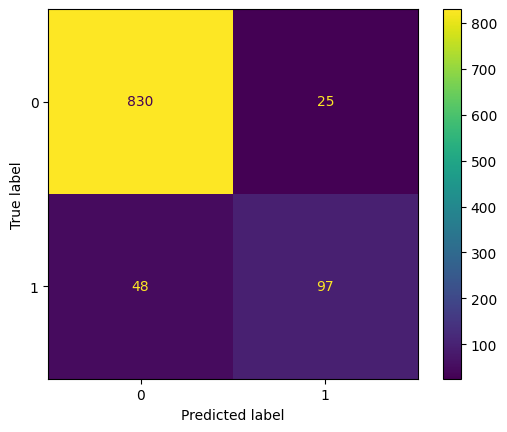

In [4]:
import pickle
import os

with mlflow.start_run(run_name="model building and evaluation run") as run:
    
    # create initial Random Forest model 
    # random_forest = RandomForestClassifier(
    #    n_estimators=75,        
    #    max_depth=5,            
    #    class_weight='balanced',  
    #    random_state=12345     
    #)

    # create optimized Random Forest model 
    random_forest = RandomForestClassifier(
        n_estimators=150,        
        max_depth=10,            
        class_weight='balanced',  
        random_state=12345     
    )

    # train model
    random_forest.fit(X_train, Y_train)

    # make predictions
    Y_pred = random_forest.predict(X_test)
    
    # calculate metrics manually
    precision = precision_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    accuracy = accuracy_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    
    # log metrics
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("F1 Score", f1)
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.log_metric("Recall", recall)
    
    # log model hyperparameters
    ''' OLD hyperparameters
    mlflow.log_param("n_estimators", 75)
    mlflow.log_param("max_depth", 5)
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("random_state", 12345)
    mlflow.log_param("model_type", "RandomForestClassifier")
    '''
    mlflow.log_param("n_estimators", 150)
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("random_state", 12345)
    mlflow.log_param("model_type", "RandomForestClassifier")

    # Log confusion matrix
    cm = confusion_matrix(Y_test, random_forest.predict(X_test), labels=random_forest.classes_)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=random_forest.classes_
    )
    mlflow.log_figure(disp.plot().figure_, "test_set_confusion_matrix.png")
    
    # workaround for version issues
    # manually save model and log it as an artifact
    
    # save model to temporary pickle file
    model_filename = "random_forest_model.pkl"
    with open(model_filename, 'wb') as f:
        pickle.dump(random_forest, f)
    
    # log pickle model as an artifact
    mlflow.log_artifact(model_filename, artifact_path="model")
    
    # clean up temp file
    os.remove(model_filename)
    
    
    

##### Registering the model

In [5]:
# find our experiment ID using name
experiment_id = mlflow.get_experiment_by_name("mini-project-experiment").experiment_id
print(experiment_id)

4fe9e28e-7f9d-4023-857b-78d39d0f636c


In [6]:
# with our experiment ID, display all the runs
mlflow.search_runs(
    experiment_ids=[experiment_id],
    filter_string="attributes.status='Finished'",
    order_by=["attributes.start_time DESC"]
)

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Accuracy,metrics.F1 Score,metrics.Recall,metrics.Precision,...,params.bootstrap,params.n_jobs,params.max_samples,params.criterion,params.verbose,tags.mlflow.user,tags.mlflow.rootRunId,tags.mlflow.runName,tags.estimator_name,tags.estimator_class
0,e9c9339c-9457-4c61-aa5c-97180c3669ba,4fe9e28e-7f9d-4023-857b-78d39d0f636c,FINISHED,,2025-10-28 01:10:14.360000+00:00,2025-10-28 01:10:19.099000+00:00,0.927,0.726592,0.668966,0.795082,...,None,None,None,None,None,Andy Foreman,e9c9339c-9457-4c61-aa5c-97180c3669ba,model building and evaluation run,None,None
1,75083274-8b9a-49f7-a953-7c102f7d25e1,4fe9e28e-7f9d-4023-857b-78d39d0f636c,FINISHED,,2025-10-28 01:06:40.803000+00:00,2025-10-28 01:06:46.400000+00:00,0.927,0.726592,0.668966,0.795082,...,None,None,None,None,None,Andy Foreman,75083274-8b9a-49f7-a953-7c102f7d25e1,model building and evaluation run,None,None
2,fa31f221-acf2-4c61-986d-195834dece4c,4fe9e28e-7f9d-4023-857b-78d39d0f636c,FINISHED,,2025-10-28 01:06:28.433000+00:00,2025-10-28 01:06:34.895000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,Andy Foreman,fa31f221-acf2-4c61-986d-195834dece4c,data prep run,None,None
3,951a9f06-8357-4635-bf7d-69deec9c6fce,4fe9e28e-7f9d-4023-857b-78d39d0f636c,FINISHED,,2025-10-25 21:39:06.601000+00:00,2025-10-25 21:39:11.159000+00:00,0.885,0.668588,0.800000,0.574257,...,None,None,None,None,None,Andy Foreman,951a9f06-8357-4635-bf7d-69deec9c6fce,model building and evaluation run,None,None
4,a524a939-4f4d-4a89-9a4d-d3651f28051c,4fe9e28e-7f9d-4023-857b-78d39d0f636c,FINISHED,,2025-10-25 21:14:00.229000+00:00,2025-10-25 21:14:06.469000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,Andy Foreman,a524a939-4f4d-4a89-9a4d-d3651f28051c,data prep run,None,None
5,0d887e65-5de1-4d62-9c1b-2ddcc8eec390,4fe9e28e-7f9d-4023-857b-78d39d0f636c,FINISHED,,2025-10-25 03:27:20.614000+00:00,2025-10-25 03:27:23.402000+00:00,NaN,0.668588,NaN,0.574257,...,True,None,None,gini,0,Andy Foreman,0d887e65-5de1-4d62-9c1b-2ddcc8eec390,model building and evaluation run,RandomForestClassifier,sklearn.ensemble._forest.RandomForestClassifier
6,6a2d9433-6d36-40df-b7be-2947fd6850ec,4fe9e28e-7f9d-4023-857b-78d39d0f636c,FINISHED,,2025-10-25 03:27:07.940000+00:00,2025-10-25 03:27:14.196000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,Andy Foreman,6a2d9433-6d36-40df-b7be-2947fd6850ec,data prep run,None,None
7,78a2a288-2554-4617-a9bf-ad132ef38401,4fe9e28e-7f9d-4023-857b-78d39d0f636c,FINISHED,,2025-10-25 03:19:20.570000+00:00,2025-10-25 03:19:24.957000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,Andy Foreman,78a2a288-2554-4617-a9bf-ad132ef38401,data prep run,None,None
8,2e984fe5-44e6-4df2-ab8c-46b686382282,4fe9e28e-7f9d-4023-857b-78d39d0f636c,FINISHED,,2025-10-25 03:18:33.360000+00:00,2025-10-25 03:18:37.521000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,Andy Foreman,2e984fe5-44e6-4df2-ab8c-46b686382282,data prep run,None,None
9,66304320-3b33-46ac-84c9-be2ede1476a3,4fe9e28e-7f9d-4023-857b-78d39d0f636c,FINISHED,,2025-10-25 03:16:03.738000+00:00,2025-10-25 03:16:10.417000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,Andy Foreman,66304320-3b33-46ac-84c9-be2ede1476a3,data prep run,None,None


In [7]:
''' select run id from above for initial model to register below
run_id = '951a9f06-8357-4635-bf7d-69deec9c6fce'
run_model = Model(
    path="runs:/"+run_id+"/model/",
    name="mini-project-random-forest-1",
    description="Initial random forest model for predicting churn",
)
'''
# optimized model 
run_id = 'e9c9339c-9457-4c61-aa5c-97180c3669ba'
run_model = Model(
    path="runs:/"+run_id+"/model/",
    name="mini-project-random-forest-1",
    description="Initial random forest model for predicting churn",
)

ml_client.models.create_or_update(run_model) 

Model({'job_name': 'e9c9339c-9457-4c61-aa5c-97180c3669ba', 'intellectual_property': None, 'system_metadata': None, 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'mini-project-random-forest-1', 'description': 'Initial random forest model for predicting churn', 'tags': {}, 'properties': {}, 'print_as_yaml': False, 'id': '/subscriptions/d33b5db8-15df-4c49-9e44-ff5ac32d6bb6/resourceGroups/bandsmlopsfall2025/providers/Microsoft.MachineLearningServices/workspaces/AzureMLOps/models/mini-project-random-forest-1/versions/2', 'Resource__source_path': '', 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/amlcomputemlops/code/Users/Shared', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x715eef3252a0>, 'serialize': <msrest.serialization.Serializer object at 0x715eef325ba0>, 'version': '2', 'latest_version': None, 'path': 'azureml://subscriptions/d33b5db8-15df-4c49-9e44-ff5ac32d6bb6/resourceGroups/bandsmlopsfal